### Trabalho de Sistemas Nebulosos

Dataset: Iris Data Set



imports das bibliotecas utilizadas

In [25]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from copy import copy
import statistics as sts
import scipy.stats as st
from math import *

#!pip install pandas
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score

#!pip install torch===1.0.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
from torch.utils.data import TensorDataset, DataLoader

import skfuzzy as fuzz

import anfis
from membership import BellMembFunc, make_bell_mfs, GaussMembFunc, make_gauss_mfs
from experimental import *

dtype = torch.float

from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

#### Preprocessamento dos dados
- Ler dataset, retirar dados que não serão utilizados, mostrar informações
- Separar em treino (70%) e test (30%), Normalização de features (0 a 1)


In [26]:
##load no dataset
data = pd.read_csv("Iris.csv")
data.pop('Id').values
data['Species'] = data['Species'].apply(lambda x: int(x =='Iris-setosa'))
y = data.pop('Species').values
## mostrando valores
print(y.shape)
print(data.shape)
print(y[-10:])
data.head(10)

(150,)
(150, 4)
[0 0 0 0 0 0 0 0 0 0]


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [27]:

#Pegando as features de cada amostra para treinar
X = data.values
print('Tamanho do vetor X: {}'.format(X.shape))#Dividindo em 5 partes de treino e teste, ou seja, 5 folds
#Dividir entre 70% treino e 30% teste
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)
##Normalização das features
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

Tamanho do vetor X: (150, 4)
(105, 4)
(45, 4)


#### Divide a parte do treino em 5 folds para testar os modelos

In [28]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)
print('Tamanho do vetor das folds:')
for train, val in kf.split(X_train):
    print("  TRAIN:", train.shape, "TEST:", val.shape)

Tamanho do vetor das folds:
  TRAIN: (84,) TEST: (21,)
  TRAIN: (84,) TEST: (21,)
  TRAIN: (84,) TEST: (21,)
  TRAIN: (84,) TEST: (21,)
  TRAIN: (84,) TEST: (21,)


#### Funções e treinamento do modelo n_folds vezes

In [29]:
####X,y -> x vetor de (n_samples, features)
def our_data(X, y, batch = 1024, shuft= True):
    x_t = torch.zeros(X.shape)
    y_t = torch.zeros((len(y), 1))
    for i in range(len(X)):
            x_t[i] = torch.tensor(X[i,:])
            y_t[i] = y[i]
    dl = DataLoader(TensorDataset(x_t, y_t), batch_size=batch, shuffle=shuft)
    return dl

##Criar modelo ANFIS
def model_Daniel(X_train):
    invardefs = []
    for i in range(X_train.shape[-1]):
        invardefs.append(('x'+str(i), make_gauss_mfs(0.3,[0.7])))

    outvars = ['y']
    model = anfis.AnfisNet('model_define', invardefs, outvars)
    return model

#calc accuracy
def calc_acc(y_pred, y_actual):
    with torch.no_grad():
        tot_loss = F.mse_loss(y_pred, y_actual)
        rmse = torch.sqrt(tot_loss).item()
        perc_loss = torch.mean(100. * torch.abs((y_pred - y_actual)
                               / y_actual))
    return(tot_loss, rmse, perc_loss)


def my_train_anfis_with(model, data, optimizer, criterion,
                     epochs=500, show_plots=False):
    '''
        Train the given model using the given (x,y) data.
    '''
    errors = []  # Keep a list of these for plotting afterwards
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    print('### Training for {} epochs, training size = {} cases'.
          format(epochs, data.dataset.tensors[0].shape[0]))
    for t in range(epochs):
        # Process each mini-batch in turn:
        for x, y_actual in data:
            y_pred = model(x)
            # Compute and print loss
            loss = criterion(y_pred, y_actual)
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Epoch ending, so now fit the coefficients based on all data:
        x, y_actual = data.dataset.tensors
        with torch.no_grad():
            model.fit_coeff(x, y_actual)
        # Get the error rate for the whole batch:
        y_pred = model(x)
        mse, rmse, perc_loss = calc_error(y_pred, y_actual)
        errors.append(perc_loss)
        # Print some progress information as the net is trained:
        if epochs < 30 or t % 10 == 0:
            print('epoch {:4d}: Erro={:.5f}'
                  .format(t, mse))
    # End of training, so graph the results:
    if show_plots:
        plotErrors(errors)
        y_actual = data.dataset.tensors[1]
        y_pred = model(data.dataset.tensors[0])
        plotResults(y_actual, y_pred)

        
def my_train_model(model, data, epochs=500, show_plots=False):
    '''
        Train the given model using the given (x,y) data.
    '''
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.99)
    criterion = torch.nn.MSELoss(reduction='mean')
    my_train_anfis_with(model, data, optimizer, criterion, epochs, show_plots)

    
def my_test_model(model, data, show_plots=False):
    '''
        Do a single forward pass with x and compare with y_actual.
    '''
    x, y_actual = data.dataset.tensors
    if show_plots:
        plot_all_mfs(model, x)
    print('### Testing for {} cases'.format(x.shape[0]))
    y_pred = model(x)
    y_pred_c = [] 
    for y_p in y_pred:
        if y_p >= 0.5:
            y_pred_c.append(1)
        else:
            y_pred_c.append(0)
    y_pred = np.array(y_pred_c)
    acc = accuracy_score(y_actual, y_pred)
    pre = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    print('Accuracy={:.2f}%  Precision={:.2f}% Recall={:.2f}%'.format(acc*100,pre*100,recall*100))
    return acc, pre, recall


#define the model
epochs = 30
show_plots = True
ACC, precision, recall = [], [], []

for train, val in kf.split(X_train):
    x_train, x_val = X_train[train], X_train[val]
    y_train, y_val = Y_train[train], Y_train[val]
    
    
    #utilizar modelo de Fuzzy-Cmeans para encontrar os centros iniciais --- IDEIA
    
    model = model_Daniel(x_train)
    train_data = our_data(x_train, y_train)
    val_data = our_data(x_val, y_val)
    my_train_model(model, train_data, epochs, False)
    acc, pre, rec = my_test_model(model, val_data, False)
    ACC.append(acc)
    precision.append(pre)
    recall.append(rec)

### Training for 30 epochs, training size = 84 cases
epoch    0: Erro=0.02026
epoch   10: Erro=0.02026
epoch   20: Erro=0.02026
### Testing for 21 cases
Accuracy=100.00%  Precision=100.00% Recall=100.00%
### Training for 30 epochs, training size = 84 cases
epoch    0: Erro=0.01891
epoch   10: Erro=0.01891
epoch   20: Erro=0.01891
### Testing for 21 cases
Accuracy=100.00%  Precision=100.00% Recall=100.00%
### Training for 30 epochs, training size = 84 cases
epoch    0: Erro=0.01611
epoch   10: Erro=0.01611
epoch   20: Erro=0.01611
### Testing for 21 cases
Accuracy=100.00%  Precision=100.00% Recall=100.00%
### Training for 30 epochs, training size = 84 cases
epoch    0: Erro=0.02003
epoch   10: Erro=0.02003
epoch   20: Erro=0.02003
### Testing for 21 cases
Accuracy=100.00%  Precision=100.00% Recall=100.00%
### Training for 30 epochs, training size = 84 cases
epoch    0: Erro=0.01927
epoch   10: Erro=0.01927
epoch   20: Erro=0.01927
### Testing for 21 cases
Accuracy=100.00%  Precision=100

### Avaliação do Modelo
- Foram utilizadas as métricas Acuracia, precisão e revocação.
- Foram calculados também o intervalo de confiação com fator de 0.9 das métricas baseadas nas n_folds execuções, para analisar e comparar.

O dataset aparentemente se apresenta simples, dado o resultado o resultado em todas as folds.

In [30]:
ic_acc = st.t.interval(0.9, len(ACC) - 1, loc=np.mean(ACC), scale=st.sem(ACC))
ic_recall = st.t.interval(0.9, len(recall) - 1, loc=np.mean(recall), scale=st.sem(recall))
ic_pre = st.t.interval(0.9, len(precision) - 1, loc=np.mean(precision), scale=st.sem(precision))
print('Mean Accuracy   [{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(ACC), ic_acc[0], ic_acc[1]))
print('Mean Recall     [{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(recall), ic_recall[0], ic_recall[1]))
print('Mean Precision  [{:.4f}] IC [{:.4f}, {:.4f}]\n'.format(np.mean(precision), ic_pre[0], ic_pre[1]))

Mean Accuracy   [1.0000] IC [nan, nan]
Mean Recall     [1.0000] IC [nan, nan]
Mean Precision  [1.0000] IC [nan, nan]



/home/jesimon/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/jesimon/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


#### Plote dos resultados para cada folds


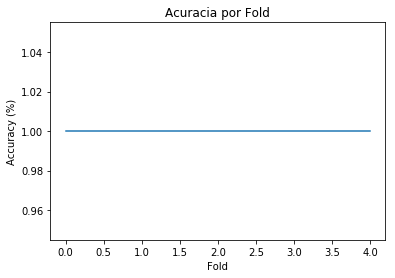

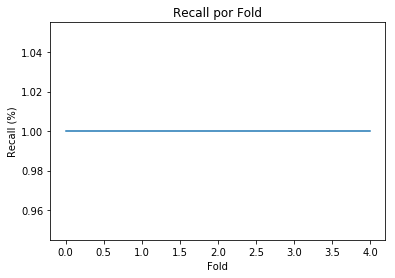

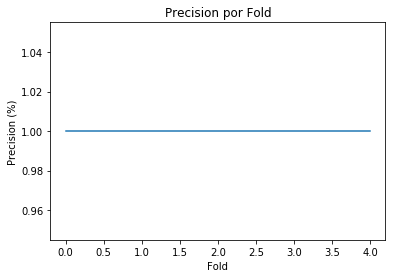

In [31]:
fig, ax = plt.subplots()
ax.plot(ACC)
ax.set(xlabel='Fold', ylabel='Accuracy (%)',
       title='Acuracia por Fold')
plt.show()

fig, ax = plt.subplots()
ax.plot(recall)
ax.set(xlabel='Fold', ylabel='Recall (%)',
       title='Recall por Fold')
plt.show()

fig, ax = plt.subplots()
ax.plot(precision)
ax.set(xlabel='Fold', ylabel='Precision (%)',
       title='Precision por Fold')
plt.show()

### Avaliação do modelo no teste
- Foram utilizadas as mesmas métricas de avaliação do treinamento
- Os valores no teste ficaram ainda maiores do que no treinamento, indicando que não houve nenhum tipo de overfitting, do mesmo modo que não está acontecendo underfitting

Os resultados derão 100%

In [32]:
test_data = our_data(X_test, Y_test)
acc, pre, rec = my_test_model(model, test_data, False)
print('Accuracy  {:.1f}%'.format(acc*100))
print('Recall    {:.1f}%'.format(rec*100))
print('Precision {:.1f}%'.format(pre*100))

### Testing for 45 cases
Accuracy=100.00%  Precision=100.00% Recall=100.00%
Accuracy  100.0%
Recall    100.0%
Precision 100.0%
